## Predictive Model Building

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('HR_ML.csv')

In [6]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [8]:
test = df.sample(frac=.2, axis=0, random_state=42)
train = df.drop(test.index, axis=0)

In [10]:
categorical_features = ['work_accident', 'promotion_last_5years', 'departments', 'salary']
label = 'left'

In [12]:
from deepchecks.tabular import Dataset

train_ds = Dataset(train, label=label,cat_features=categorical_features)
test_ds = Dataset(test, label=label,cat_features=categorical_features)

In [14]:
from deepchecks.tabular.suites import train_test_validation

validation_suite = train_test_validation()
suite_result = validation_suite.run(train_ds, test_ds)
suite_result

/opt/anaconda3/lib/python3.12/site-packages/deepchecks/tabular/checks/train_test_validation/train_test_samples_mix.py:85: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_6EJ3ATT76LHKFO0URIKD7OMTP">Train Test Validat…

In [16]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer

column_trans = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ['departments']),
    (OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

transformed_df = column_trans.fit_transform(df)

In [18]:
df2 = df.copy()

### Outlier Detection

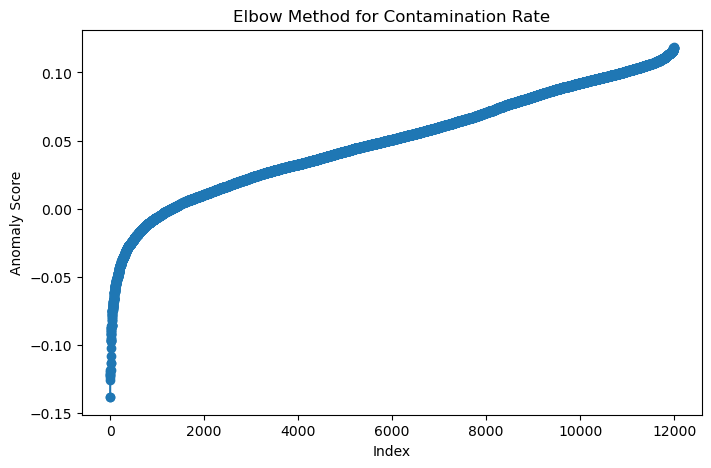

In [44]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, random_state=42)
iso_forest.fit(transformed_df)

scores = iso_forest.decision_function(transformed_df)

sorted_scores = np.sort(scores)

plt.figure(figsize=(8, 5))
plt.plot(range(len(sorted_scores)), sorted_scores, marker='o', linestyle='-')
plt.xlabel("Index")
plt.ylabel("Anomaly Score")
plt.title("Elbow Method for Contamination Rate")
plt.show()

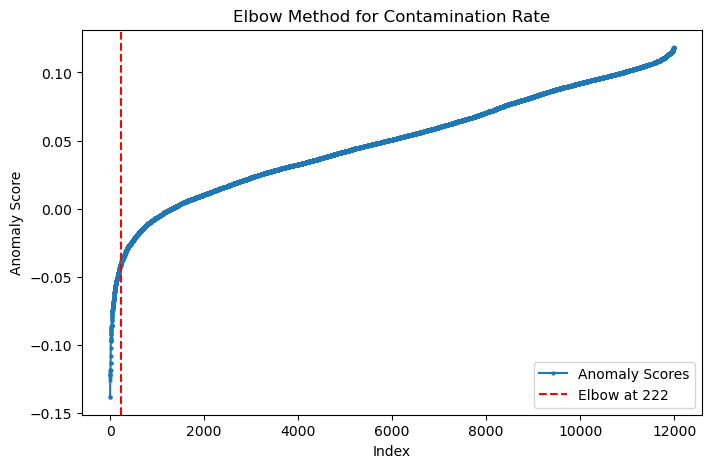

Suggested Contamination Rate: 0.0185


0.018513885414060547

In [46]:
from kneed import KneeLocator

def find_elbow_point(anomaly_scores):
    """
    Finds the elbow point in anomaly scores using the KneeLocator method.
    """
    sorted_scores = np.sort(anomaly_scores)  # Sort the anomaly scores
    index = np.arange(len(sorted_scores))  # Create index array

    # Use KneeLocator to find the elbow point
    kneedle = KneeLocator(index, sorted_scores, curve="concave", direction="increasing")

    elbow_index = kneedle.knee

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(index, sorted_scores, label="Anomaly Scores", marker="o", markersize=2)
    plt.axvline(x=elbow_index, color="r", linestyle="--", label=f"Elbow at {elbow_index}")
    plt.xlabel("Index")
    plt.ylabel("Anomaly Score")
    plt.title("Elbow Method for Contamination Rate")
    plt.legend()
    plt.show()

    # Estimate contamination rate
    contamination_rate = elbow_index / len(anomaly_scores)
    print(f"Suggested Contamination Rate: {contamination_rate:.4f}")

    return contamination_rate

find_elbow_point(scores)

In [48]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.0185, random_state=42)
df2['outlier'] = iso_forest.fit_predict(transformed_df)

df2[df2.outlier == -1]

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary,outlier
18,0.45,0.51,2,160,3,1,1,1,sales,low,-1
68,0.76,0.86,5,223,5,1,1,0,product_mng,medium,-1
75,0.11,0.79,7,306,4,0,1,0,product_mng,medium,-1
82,0.79,0.59,4,139,3,0,1,1,management,low,-1
111,0.09,0.85,6,289,4,0,1,0,hr,high,-1
...,...,...,...,...,...,...,...,...,...,...,...
11985,0.22,0.94,3,193,10,0,0,1,management,high,-1
11986,0.90,0.55,3,259,10,1,0,1,management,high,-1
11987,0.74,0.95,5,266,10,0,0,1,management,high,-1
11988,0.85,0.54,3,185,10,0,0,1,management,high,-1


In [50]:
len(df2[df2.outlier == -1]) / len(df2)

0.018513885414060547

In [52]:
df.drop(df2[df2.outlier == -1].index, axis=0, inplace=True)

In [54]:
df.shape

(11769, 10)

### Preprocessing

In [56]:
X = df.drop('left', axis=1)
y = df.left

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify = y, random_state=42)

In [62]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,departments,salary
3058,0.89,0.61,3,175,4,0,0,sales,medium
83,0.84,0.85,4,249,6,0,0,marketing,low
5628,0.49,0.48,2,186,2,0,0,IT,medium
47,0.57,0.70,3,273,6,0,0,support,low
7985,0.57,0.58,3,251,3,0,0,technical,medium


In [64]:
X_test.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,departments,salary
7260,0.97,0.84,3,223,3,0,0,sales,low
10476,0.62,0.79,5,172,3,0,0,accounting,low
121,0.40,0.46,2,135,3,0,0,technical,low
1827,0.61,0.58,2,264,4,0,0,technical,low
7626,0.57,0.88,3,176,3,0,0,support,low


In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

column_trans2 = make_column_transformer(
    (OneHotEncoder(sparse_output=False), ['departments']),
    (OrdinalEncoder(categories=[['low', 'medium', 'high']]), ['salary']),
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

operations = [("column_trans", column_trans2),("scaler", StandardScaler()), ("logistic", LogisticRegression())]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['departments']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']]),
                                                  ['salary'])],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

In [70]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

Test_Set
[[1897   74]
 [ 311   72]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1971
           1       0.49      0.19      0.27       383

    accuracy                           0.84      2354
   macro avg       0.68      0.58      0.59      2354
weighted avg       0.80      0.84      0.80      2354


Train_Set
[[7552  332]
 [1269  262]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      7884
           1       0.44      0.17      0.25      1531

    accuracy                           0.83      9415
   macro avg       0.65      0.56      0.58      9415
weighted avg       0.79      0.83      0.80      9415



In [72]:
from sklearn.model_selection import cross_validate

operations = [("column_trans", column_trans2),("scaler", StandardScaler()), ("logistic", LogisticRegression())]

model = Pipeline(steps=operations)

scores = cross_validate(model, 
                        X_train, 
                        y_train, 
                        scoring = ['precision',
                                   'recall',
                                   'f1',
                                   'accuracy',
                                   'average_precision'], 
                        cv=10, 
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1,11))
df_scores.mean()[2:]

test_precision             0.433654
train_precision            0.440067
test_recall                0.168543
train_recall               0.170476
test_f1                    0.241362
train_f1                   0.245736
test_accuracy              0.828781
train_accuracy             0.829846
test_average_precision     0.404947
train_average_precision    0.401911
dtype: float64

In [74]:
pipe_model['logistic'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [76]:
from sklearn.model_selection import GridSearchCV

operations = [("column_trans", column_trans2),("scaler", StandardScaler()), ("logistic", LogisticRegression(max_iter=1500))]

pipe_model = Pipeline(steps=operations)

param_grid = param_grid = {"logistic__penalty" : ['l1', 'l2'],
              "logistic__C" : [0.01, 0.1, 1, 5],
              "logistic__class_weight":["balanced", None],
              "logistic__solver":["liblinear", "saga"]}

log_grid_model = GridSearchCV(estimator=pipe_model,
                          param_grid=param_grid,
                          cv=10,
                          scoring = "recall",
                          n_jobs = -1,
                          return_train_score=True)

log_grid_model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['departments']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['low',
                                                                                                     'medium',
                                                                                                     'high']]),
                                                                         ['salary'])],
                                                          verbose_feature_names_out=False)),
                                       ('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=1500))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.01, 0.1, 1, 5],
                         'logistic__class_weight': ['balanced', None],
                         'logistic__penalty': ['l1', 'l2'],
                         'logistic__solver': ['liblinear', 'saga']},
             return_train_score=True, scoring='recall')

In [78]:
eval_metric(log_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[1501  470]
 [  48  335]]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      1971
           1       0.42      0.87      0.56       383

    accuracy                           0.78      2354
   macro avg       0.69      0.82      0.71      2354
weighted avg       0.88      0.78      0.81      2354


Train_Set
[[5968 1916]
 [ 233 1298]]
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      7884
           1       0.40      0.85      0.55      1531

    accuracy                           0.77      9415
   macro avg       0.68      0.80      0.70      9415
weighted avg       0.87      0.77      0.80      9415



In [80]:
log_grid_model.best_params_

{'logistic__C': 0.01,
 'logistic__class_weight': 'balanced',
 'logistic__penalty': 'l1',
 'logistic__solver': 'liblinear'}

In [82]:
y_pred = log_grid_model.predict(X_test)

log_recall = recall_score(y_test, y_pred)

### Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier

operations = [("column_trans", column_trans2),("scaler", StandardScaler()), 
              ("rf", RandomForestClassifier(random_state=42, class_weight='balanced'))]

pipe_model_rf = Pipeline(steps=operations)

pipe_model_rf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('column_trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['departments']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']]),
                                                  ['salary'])],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [86]:
eval_metric(pipe_model_rf, X_train, y_train, X_test, y_test)

Test_Set
[[1967    4]
 [  29  354]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1971
           1       0.99      0.92      0.96       383

    accuracy                           0.99      2354
   macro avg       0.99      0.96      0.97      2354
weighted avg       0.99      0.99      0.99      2354


Train_Set
[[7884    0]
 [   1 1530]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7884
           1       1.00      1.00      1.00      1531

    accuracy                           1.00      9415
   macro avg       1.00      1.00      1.00      9415
weighted avg       1.00      1.00      1.00      9415



In [88]:
pipe_model_rf['rf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_features': ['sqrt', 'log2'],  
    'rf__max_depth': [4, 6, 8],
    'rf__min_samples_split': [2, 4],  
    'rf__min_samples_leaf': [1, 2, 5],  
    'rf__max_samples': [0.5, 0.7, 0.8]
}

operations = [("column_trans", column_trans2),("scaler", StandardScaler()), 
              ("rf", RandomForestClassifier(random_state=42, class_weight='balanced'))]

pipe = Pipeline(steps = operations)

rf_grid_model = GridSearchCV(pipe,
                             param_grid,
                             scoring="recall",
                             cv=5,
                             n_jobs=-1,
                             verbose=2)

rf_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END rf__max_depth=4, rf__max_features=sqrt, rf__max_samples=0.5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=4, rf__max_features=sqrt, rf__max_samples=0.5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=4, rf__max_features=sqrt, rf__max_samples=0.5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=150; total time=   0.9s
[CV] END rf__max_depth=4, rf__max_features=sqrt, rf__max_samples=0.5, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   1.8s
[CV] END rf__max_depth=4, rf__max_features=sqrt, rf__max_samples=0.5, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=100; total time=   0.9s
[CV] END rf__max_depth=4, rf__max_features=sqrt, rf__max_samples=0.5, rf__min_samples_leaf=1, rf__min_samples_split=4, rf__n_estimators=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(sparse_output=False),
                                                                         ['departments']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['low',
                                                                                                     'medium',
                                                                                                     'high']]),
                                                                         ['salary'])],
                                                          verbose_feature_names_out=False)),
                                       ('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [4, 6, 8],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__max_samples': [0.5, 0.7, 0.8],
                         'rf__min_samples_leaf': [1, 2, 5],
                         'rf__min_samples_split': [2, 4],
                         'rf__n_estimators': [100, 150, 200]},
             scoring='recall', verbose=2)

In [92]:
eval_metric(rf_grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[1898   73]
 [  31  352]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1971
           1       0.83      0.92      0.87       383

    accuracy                           0.96      2354
   macro avg       0.91      0.94      0.92      2354
weighted avg       0.96      0.96      0.96      2354


Train_Set
[[7564  320]
 [ 117 1414]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7884
           1       0.82      0.92      0.87      1531

    accuracy                           0.95      9415
   macro avg       0.90      0.94      0.92      9415
weighted avg       0.96      0.95      0.95      9415



In [94]:
rf_grid_model.best_params_

{'rf__max_depth': 4,
 'rf__max_features': 'sqrt',
 'rf__max_samples': 0.8,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 100}

In [96]:
y_pred = rf_grid_model.predict(X_test)

rf_recall = recall_score(y_test, y_pred)

In [98]:
rf_recall

0.9190600522193212

### DeepChecks Model_Evaluation

In [100]:
from deepchecks.tabular import Dataset

train_ds = Dataset(X_train, label=y_train, cat_features=[])
test_ds = Dataset(X_test, label=y_test, cat_features=[])

In [102]:
from deepchecks.tabular.suites import model_evaluation

evaluation_suite = model_evaluation()
suite_result = evaluation_suite.run(train_ds, test_ds, rf_grid_model)
suite_result.show()

deepchecks - WARNING - Could not find built-in feature importance on the model, using permutation feature importance calculation instead
deepchecks - INFO - Calculating permutation feature importance. Expected to finish in 8 seconds


Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_DIE1SNTIU33VDO7NJZLYG1ZJO">Model Evaluation S…

### XGBoost

In [104]:
from xgboost import XGBClassifier

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [106]:
X_train.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,departments,salary
3058,0.89,0.61,3,175,4,0,0,sales,medium
83,0.84,0.85,4,249,6,0,0,marketing,low
5628,0.49,0.48,2,186,2,0,0,IT,medium
47,0.57,0.70,3,273,6,0,0,support,low
7985,0.57,0.58,3,251,3,0,0,technical,medium


In [108]:
X_train_trans = column_trans2.fit_transform(X_train)
X_test_trans = column_trans2.transform(X_test)

In [110]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train_trans, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [112]:
eval_metric(xgb_model, X_train_trans, y_train, X_test_trans, y_test)

Test_Set
[[1960   11]
 [  27  356]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1971
           1       0.97      0.93      0.95       383

    accuracy                           0.98      2354
   macro avg       0.98      0.96      0.97      2354
weighted avg       0.98      0.98      0.98      2354


Train_Set
[[7881    3]
 [  28 1503]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7884
           1       1.00      0.98      0.99      1531

    accuracy                           1.00      9415
   macro avg       1.00      0.99      0.99      9415
weighted avg       1.00      1.00      1.00      9415



In [120]:
y_pred = xgb_model.predict(X_test_trans)

xgb_vanilla_recall = recall_score(y_test, y_pred)
xgb_vanilla_recall

0.9295039164490861

In [116]:
from deepchecks.tabular import Dataset

train_ds = Dataset(X_train_trans, label=y_train, cat_features=[])
test_ds = Dataset(X_test_trans, label=y_test, cat_features=[])

In [118]:
from deepchecks.tabular.suites import model_evaluation

evaluation_suite = model_evaluation()
suite_result = evaluation_suite.run(train_ds, test_ds, xgb_model)
suite_result.show()

Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_6XYYG4TDZHN8UF0EK4C0KCHFS">Model Evaluation S…

In [122]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],  
    "max_depth": [4, 5],  
    "learning_rate": [0.05, 0.1],  
    "subsample": [0.5, 0.7, 0.8],  
    "colsample_bytree": [0.5, 0.7],  
    "gamma": [0.1, 0.3, 0.5]
}


xgb_grid = GridSearchCV(XGBClassifier(),
                        param_grid,
                        scoring="recall",
                        verbose=2,
                        n_jobs=-1,
                        cv=5,
                        return_train_score=True)

xgb_grid.fit(X_train_trans, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.4s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.5; total time=   0.5s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.5, gamma=0.1, learni

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'gamma': [0.1, 0.3, 0.5], 'learning_rate': [0.05, 0.1],
                         'max_depth': [4, 5], 'n_estimators': [100, 200],
                         'subsample': [0.5, 0.7, 0.8]},
             return_train_score=True, scoring='recall', verbose=2)

In [124]:
eval_metric(xgb_grid, X_train_trans, y_train, X_test_trans, y_test)

Test_Set
[[1960   11]
 [  27  356]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1971
           1       0.97      0.93      0.95       383

    accuracy                           0.98      2354
   macro avg       0.98      0.96      0.97      2354
weighted avg       0.98      0.98      0.98      2354


Train_Set
[[7860   24]
 [ 105 1426]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7884
           1       0.98      0.93      0.96      1531

    accuracy                           0.99      9415
   macro avg       0.99      0.96      0.97      9415
weighted avg       0.99      0.99      0.99      9415



In [130]:
y_pred = xgb_grid.predict(X_test_trans)

xgb_grid_recall = recall_score(y_test, y_pred)
xgb_grid_recall

0.9295039164490861

In [132]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 200,
 'subsample': 0.8}

In [140]:
log_recall

0.8746736292428199

In [142]:
rf_recall

0.9190600522193212

In [146]:
xgb_grid_recall

0.9295039164490861

In [148]:
scores_dict = {
    'logistic' : log_recall,
    'random forest' : rf_recall,
    'xg boost' : xgb_grid_recall
}

compare = pd.DataFrame(scores_dict, index=[0])

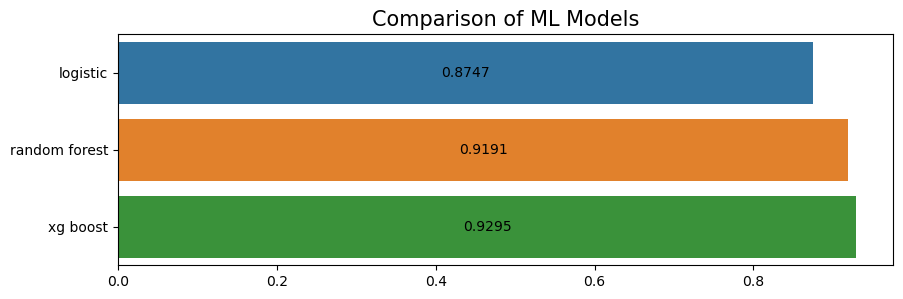

In [150]:
plt.figure(figsize=(10,3))
ax = sns.barplot(compare, orient='h')
for container in ax.containers:
    plt.bar_label(container, label_type='center', fmt='%.4f')
plt.title('Comparison of ML Models', fontdict={'fontsize':15})
plt.show()

### Prediction

In [152]:
df.sample(1)

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,departments,salary
11178,0.49,0.91,4,134,4,0,0,0,accounting,low


In [160]:
pred_dict = {
    'satisfaction_level':0.34,
    'last_evaluation':0.65,
    'number_project':3,
    'average_monthly_hours':249,
    'time_spend_company':2,
    'work_accident':0,
    'promotion_last_5years':0,
    'departments': 'technical',
    'salary':'medium'
}

pred_df = pd.DataFrame(pred_dict, index=[0])

In [162]:
pred_trans = column_trans2.transform(pred_df)

prediction = xgb_grid.predict(pred_trans)
prediction

array([0])